In [16]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [17]:

def read_graph_from_gml(file):
    G = nx.read_gml(file)
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
    nx.set_node_attributes(G, pos, name='pos')
    return G

def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
    node1, node2 = edge
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(R * c, 5)

In [18]:
# import geopandas
# states = geopandas.read_file('data/usa-states-census-2014.shp')
# type(states)

In [19]:
G_full = read_graph_from_gml("ESnet2.gml")
e_to_be_removed = [('EQXDC4','EQXCH2'),('WASH','NASH'),('WASH','ATLA'),('JLAB','ATLA')]
G_full.remove_edges_from(e_to_be_removed)
pos_list = nx.get_node_attributes(G_full, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
max_dist = 25
left_ESnet_subgraph = False
G = G_full.copy()
for node in G_full.nodes():
    if pos_list[node][0]<-90:
        G.remove_node(node)

orig_edges = np.copy(G.edges())

connected_components = nx.connected_components(G)
for conn_component in connected_components:
    if "PPPL" not in conn_component:
        left_sub_graph = conn_component
    else:
        right_sub_graph = conn_component


if left_ESnet_subgraph:
    for node in right_sub_graph:
        G.remove_node(node)
else:
    for node in left_sub_graph:
        G.remove_node(node)
connected_components = nx.connected_components(G)
for conn_component in connected_components:
    print("we have this sub graph with these nodes",type(conn_component),conn_component)

# we have 12 non-integer node IDs
#         mapping = {0: "a", 1: "b", 2: "c"}
mapping_from_string_to_integer_in_ESnet = {}
node_id_counter = 0
for node in G.nodes:
    mapping_from_string_to_integer_in_ESnet[node] = node_id_counter 
    pos_list[node_id_counter] = pos_list[node]
    node_id_counter+=1
print("mapping_from_string_to_integer_in_ESnet ",mapping_from_string_to_integer_in_ESnet)
G = nx.relabel_nodes(G, mapping_from_string_to_integer_in_ESnet)
orig_edges = np.copy(G.edges())
c_edge = 0
c_rep = 0
c_edge = len(G.nodes)
c_rep = len(G.nodes)

weights = dict()
for edge in orig_edges:
    dist = compute_dist_lat_lon(edge,G)
    if dist >= 2*max_dist:
        n1, n2 = edge
        G.remove_edge(n1,n2)
        c_edge += 1
        n_rep = int(dist/max_dist)-1
        G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
        G.add_edge(n1,c_rep)
        weights[(n1,c_rep)] = dist/(n_rep+1)
        i_r = 0
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        G.add_edge(c_rep+n_rep-1,n2)
        weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
        i_r = n_rep -1
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        for i_r in range(0,n_rep-1):
            G.add_edge(i_r+c_rep,i_r+c_rep+1)
            pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)
            
        c_rep += n_rep
    else:
        n1, n2 = edge
        weights[(n1,n2)] = dist
        
nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % (2*max_dist),c_edge)
print("No. of aux. nodes=",c_rep)
print("Total No. nodes=",len(G.nodes()))

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'
            
# for node in G.nodes:
#     print("node is ",node)

we have this sub graph with these nodes <class 'set'> {'WASH', 'BOST', 'BNL', 'EQXDC4', 'NETLMGN', 'JLAB', 'NEWY1118TH', 'NETLPGH', 'NEWY32AOA', 'PSFC', 'PPPL'}
mapping_from_string_to_integer_in_ESnet  {'BNL': 0, 'BOST': 1, 'EQXDC4': 2, 'JLAB': 3, 'NETLPGH': 4, 'NEWY1118TH': 5, 'NEWY32AOA': 6, 'PPPL': 7, 'WASH': 8, 'PSFC': 9, 'NETLMGN': 10}
No. of modified edges longer than 50 km:  18
No. of aux. nodes= 70
Total No. nodes= 70


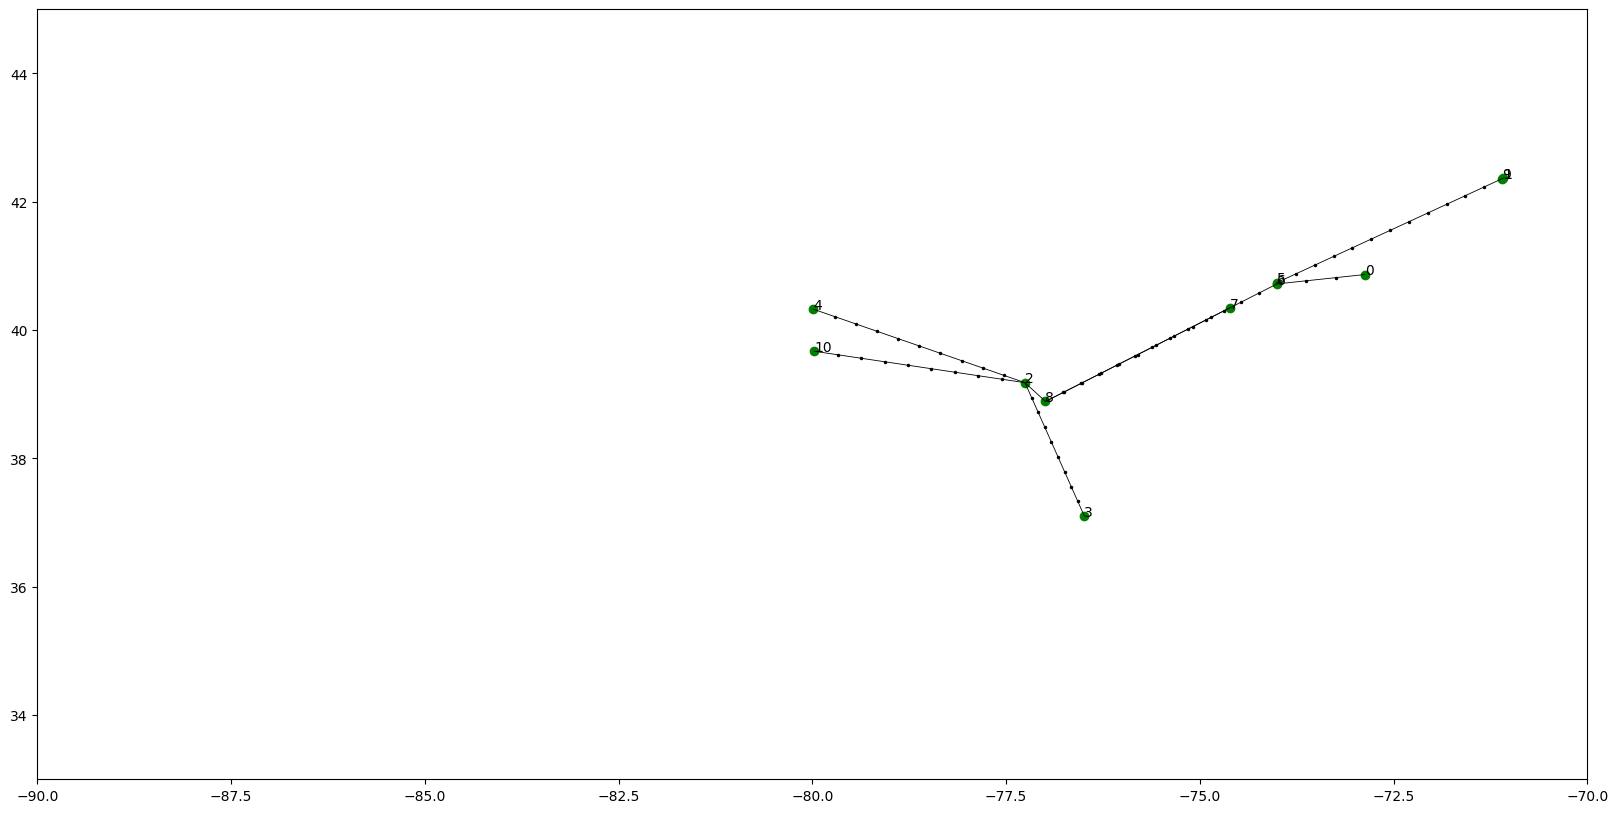

In [20]:
# fig,ax = plt.subplots(figsize = (15,15))
# states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# east coast
xmin, xmax = -90,-70
ymin, ymax = 33,45

# chatanooga
# xmin, xmax = -86,-83
# ymin, ymax = 34,37

# # chicago
# xmin, xmax = -88.3,-87
# ymin, ymax = 41,42

# # new york
# xmin, xmax = -74.7,-72.5
# ymin, ymax = 40,41

fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.6)

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.show()

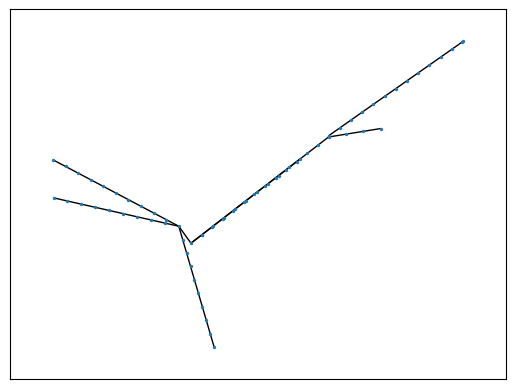

In [22]:
# print(G.nodes())
nx.draw_networkx(G,pos=pos_list,with_labels=False,node_size=2,font_size=8)



# for presentation only

In [23]:
G_full = read_graph_from_gml("ESnet2.gml")
pos_list = nx.get_node_attributes(G_full, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
max_dist = 50

G = G_full.copy()
for node in G_full.nodes():
    if pos_list[node][0]<-90:
        G.remove_node(node)

pos_list["PPPL"][0] -= 0.3

orig_edges = np.copy(G.edges())
c_edge = 0
c_rep = 0
weights = dict()
for edge in orig_edges:
    dist = compute_dist_lat_lon(edge,G)
    if dist >= 2*max_dist:
        n1, n2 = edge
        G.remove_edge(n1,n2)
        c_edge += 1
        n_rep = int(dist/max_dist)-1
        G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
        G.add_edge(n1,c_rep)
        weights[(n1,c_rep)] = dist/(n_rep+1)
        i_r = 0
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        G.add_edge(c_rep+n_rep-1,n2)
        weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
        i_r = n_rep -1
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        for i_r in range(0,n_rep-1):
            G.add_edge(i_r+c_rep,i_r+c_rep+1)
            pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)
            
        c_rep += n_rep
    else:
        n1, n2 = edge
        weights[(n1,n2)] = dist
        
nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % max_dist,c_edge)
print("No. of aux. nodes=",c_rep)
print("Total No. nodes=",len(G.nodes()))

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'

No. of modified edges longer than 50 km:  18
No. of aux. nodes= 118
Total No. nodes= 141


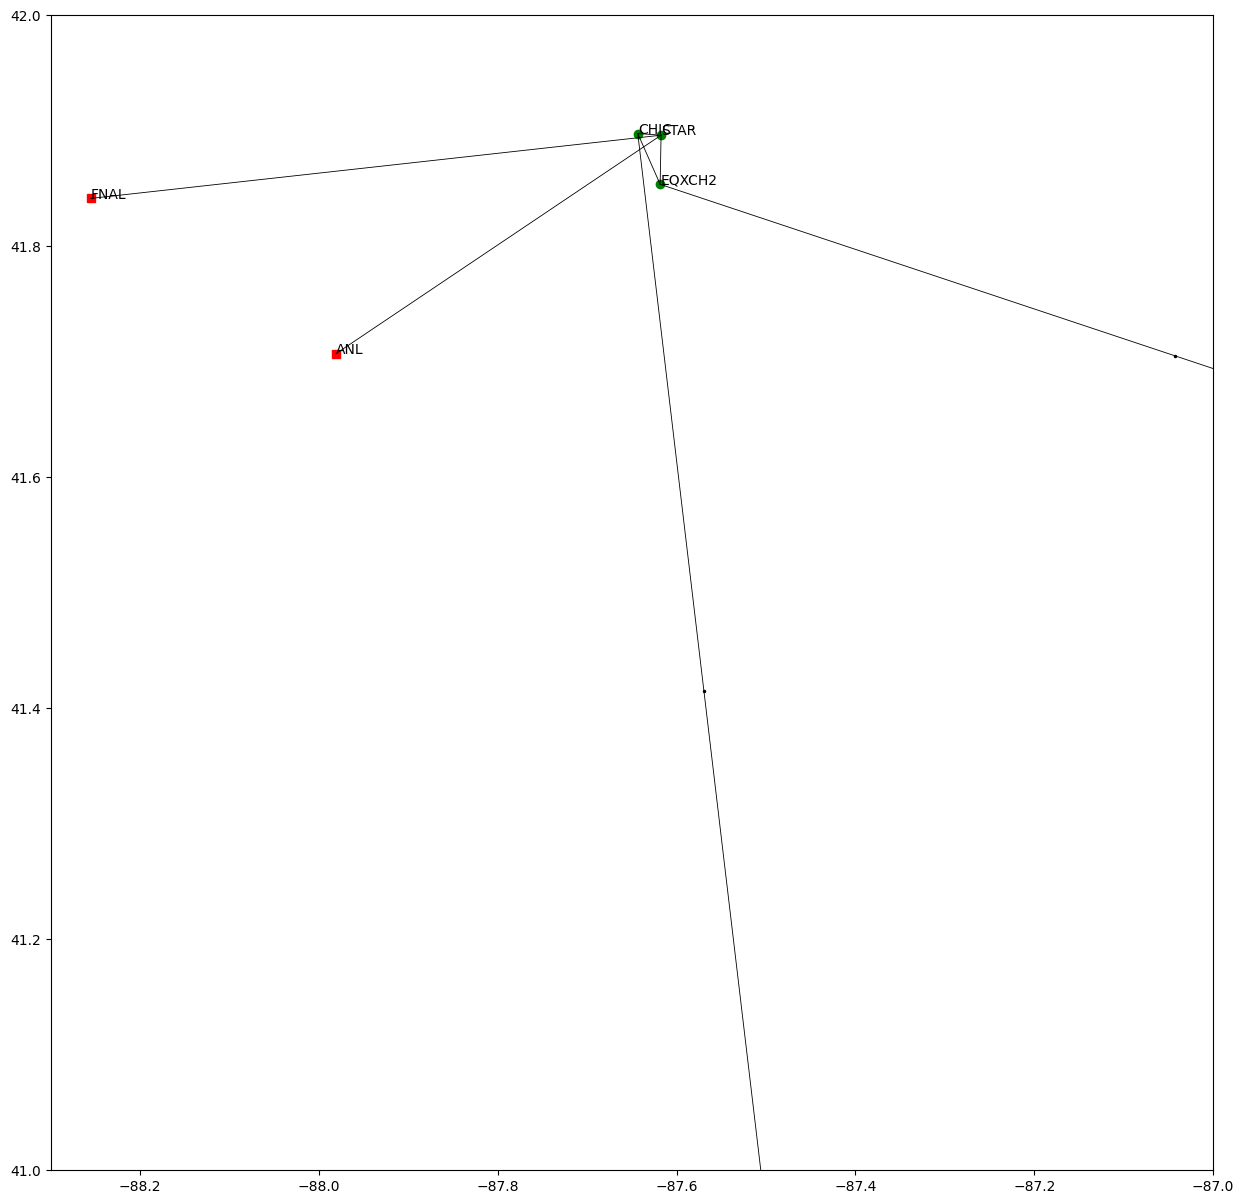

In [25]:
fig,ax = plt.subplots(figsize = (15,15))

# east coast
xmin, xmax = -90,-70
ymin, ymax = 33,45

# chicago
xmin, xmax = -88.3,-87
ymin, ymax = 41,42

# fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.6)

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.show()